In [30]:
from tvDatafeed import TvDatafeed, Interval
from datetime import datetime, timedelta
import mplfinance as mpf
import pandas as pd
import ta  # module for technical indicators
import ta.momentum
import seaborn as sns
import matplotlib.pyplot as plta
from pytz import timezone
from dotenv import load_dotenv
import os 
load_dotenv()

True

In [32]:
symbol = "AMD"
exchange = "NASDAQ"
interval = Interval.in_1_minute
n_bars = 5000

username = os.getenv("USERNAME")
password = os.getenv("PASSWORD")
tv = TvDatafeed(username, password)

ERROR:tvDatafeed.main:error while signin


In [33]:
df = tv.get_hist(symbol=symbol, exchange=exchange, interval=interval, n_bars=n_bars)
df = df.drop(columns=['symbol'])
df.reset_index(inplace=True)
df.rename(columns={'datetime': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'] - timedelta(hours=1)
df['date'] = df['date'].apply(lambda dt: dt.replace(tzinfo=timezone("US/Eastern")))
df.to_csv('../../data/stock.csv', index=False)
data = df['date'].iloc[-1]
data

Timestamp('2025-01-24 20:59:00-0500', tz='US/Eastern')

In [34]:
import exchange_calendars as ecals
calendar = ecals.get_calendar("XNYS")

def is_nasdaq_open(date):
    if not isinstance(date, pd.Timestamp):
        date = pd.Timestamp(date)
        
    if not calendar.is_session(date.date()):
        return False

    open_time, close_time = calendar.session_open_close(date.date())
    return open_time.time() <= date.time() <= close_time.time()

any_false = not all(df['date'].apply(is_nasdaq_open))
any_false

False

In [61]:
Interval.in_15_minute == Interval.in_15_minute

True

Here we will cook a dataset that is based on inputs without unbound variance range, it should work better than whats above

In [249]:
import numpy as np
import pandas as pd

# Funkcje pomocnicze
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line - signal_line

def compute_adx(high, low, close, period=14):
    tr = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)

    dm_plus = (high - high.shift(1)).clip(lower=0)
    dm_minus = (low.shift(1) - low).clip(lower=0)

    tr_smooth = tr.rolling(window=period).sum()
    dm_plus_smooth = dm_plus.rolling(window=period).sum()
    dm_minus_smooth = dm_minus.rolling(window=period).sum()

    di_plus = 100 * (dm_plus_smooth / tr_smooth)
    di_minus = 100 * (dm_minus_smooth / tr_smooth)
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    adx = dx.rolling(window=period).mean()

    return adx

def compute_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std_dev = series.rolling(window=window).std()
    upper_band = sma + (num_std * std_dev)
    lower_band = sma - (num_std * std_dev)
    return upper_band, lower_band


# Cechy cenowe
df['Log_Close'] = np.log(df['close'])
df['Price_Change'] = df['close'].pct_change()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

# RSI i MACD
df['RSI_14'] = compute_rsi(df['close'], window=14)
df['MACD'] = compute_macd(df['close'])

# Wolumen
df['Volume_MA'] = df['volume'].rolling(window=50).mean()
df['Volume_Spike'] = df['volume'] / df['Volume_MA']

# Dystans od SMA
df['SMA_20_Distance'] = (df['SMA_20'] - df['close']) / df['close']

# ADX i Bollinger Bands
df['ADX'] = compute_adx(df['high'], df['low'], df['close'], period=14)
df['Bollinger_Upper'], df['Bollinger_Lower'] = compute_bollinger_bands(df['close'])
df['Normalized_BB'] = ((df['close'] - df['Bollinger_Lower']) / (df['Bollinger_Upper'] - df['Bollinger_Lower'])) * 100

# Normalizacja
features_to_normalize = ['Price_Change', 'SMA_20_Distance', 'Volume_Spike', 'ADX', 'MACD']
for feature in features_to_normalize:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()

# Docelowa zmienna (target)
#df['Target'] = (df['close'].shift(-10).rolling(10).mean() > df['close'].rolling(10).mean()).astype(int)
#df['Target'] = (df['close'].shift(-13).rolling(window=10, min_periods=1).max() > df['close']).astype(int)
df['Target'] = (df['close'].shift(-10).rolling(10).mean() > df['close']).astype(int)

# Obsługa brakujących danych
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

/tmp/ipykernel_5600/2134311030.py:86: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Target'].iloc[i] = target_return  # Przypisanie targetu
/tmp/ipykernel_5600/2134311030.py:86: SettingWithCopyWarning: 
A value is trying to be set on a c

**Looking for correlation between features and target value:**

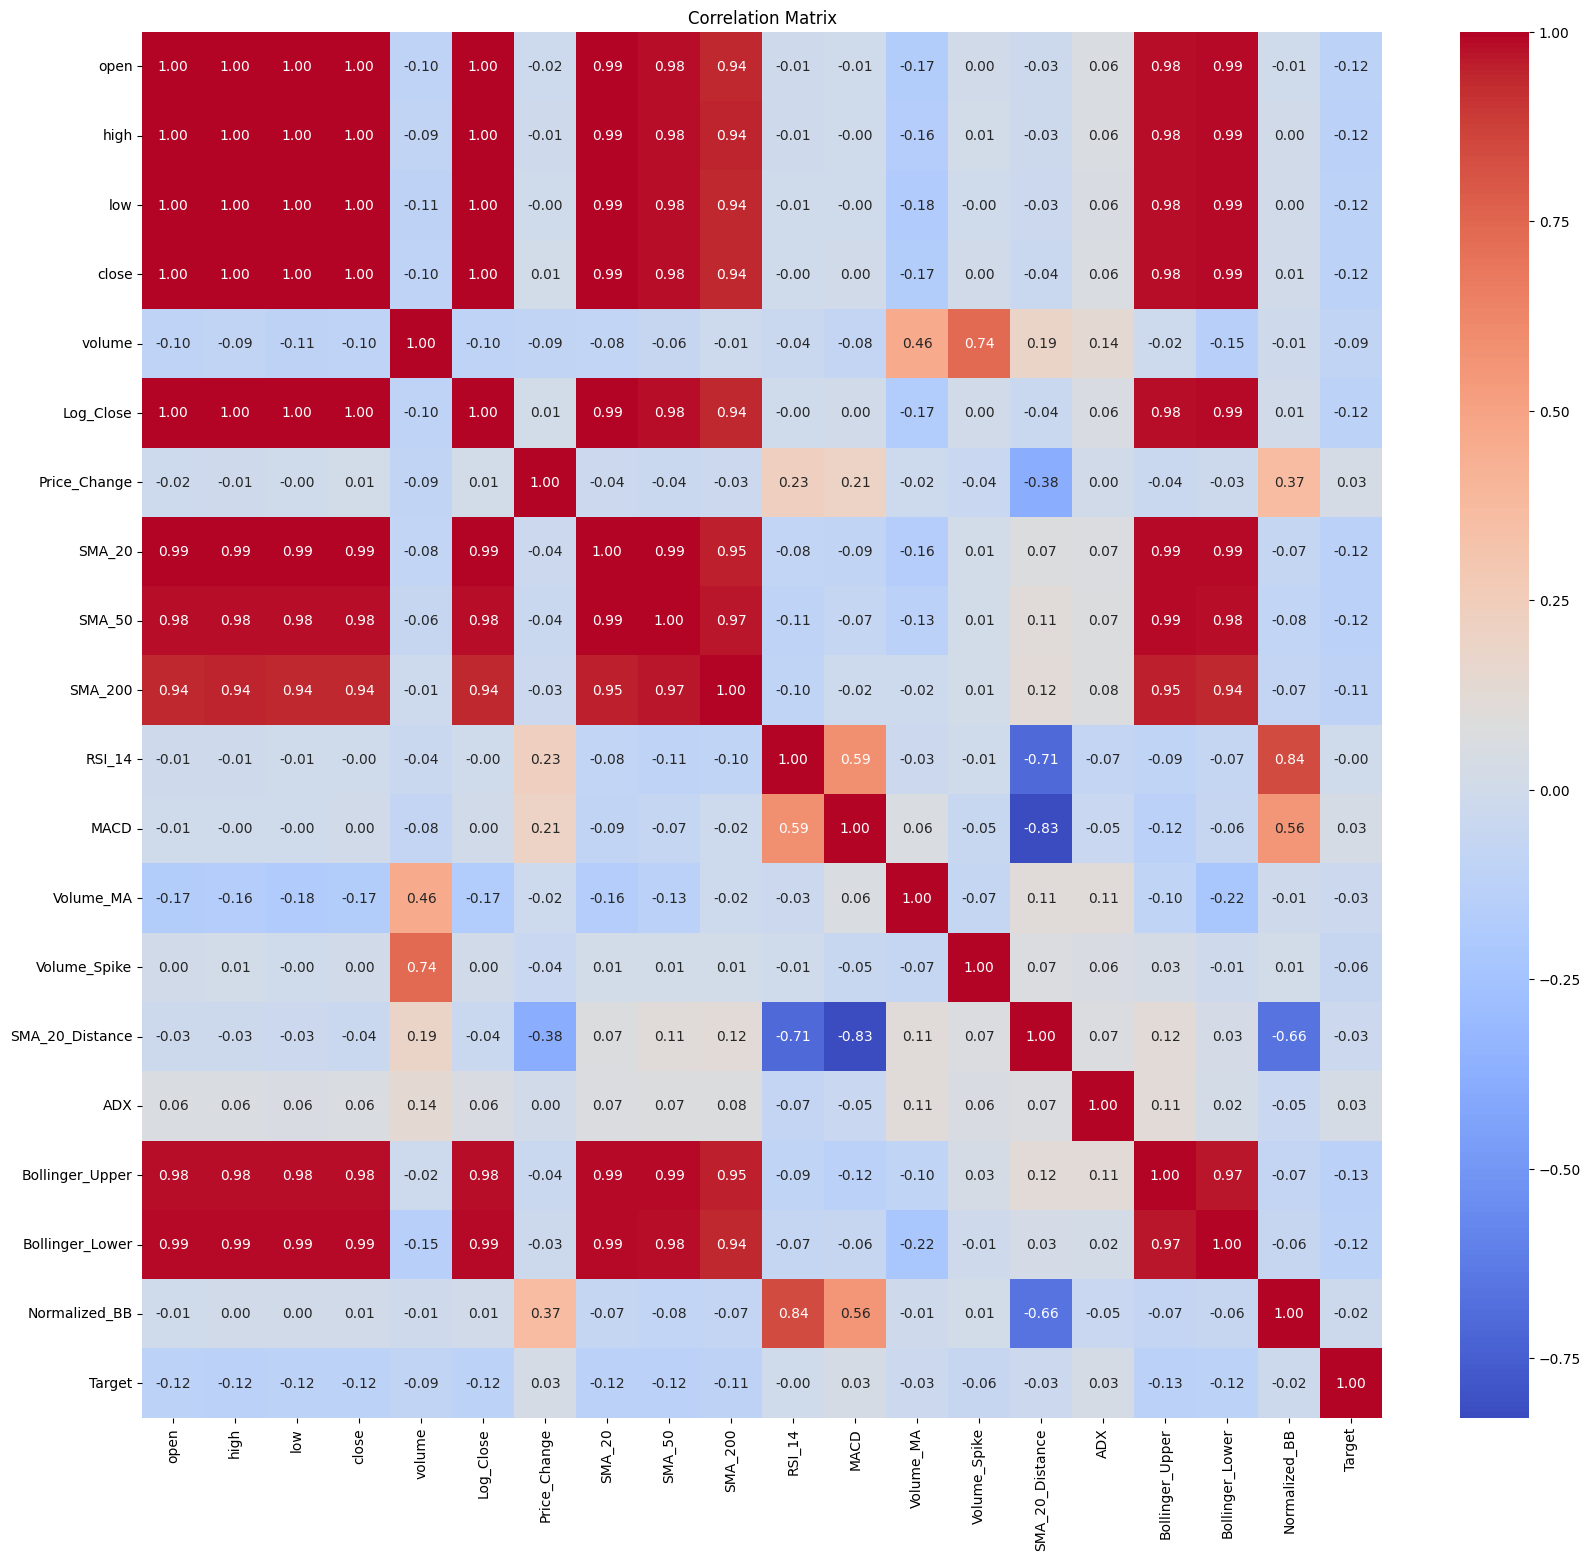

In [243]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [244]:
from scipy.stats import spearmanr

correlations = {}
for col in df.columns:
    if col != 'Target':
        correlations[col] = spearmanr(df[col], df['Target'])[0]

correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(correlations)


[('close', np.float64(-0.0842753139051374)), ('Log_Close', np.float64(-0.0842753139051374)), ('high', np.float64(-0.08332916646038915)), ('low', np.float64(-0.08288937772535772)), ('open', np.float64(-0.08223218531610706)), ('Bollinger_Upper', np.float64(-0.08016458697822977)), ('Bollinger_Lower', np.float64(-0.0789550359338888)), ('SMA_20', np.float64(-0.07876639103288308)), ('SMA_50', np.float64(-0.07560993544396258)), ('SMA_200', np.float64(-0.056113298168960865)), ('ADX', np.float64(0.049848571254290486)), ('Normalized_BB', np.float64(-0.045021317874010376)), ('SMA_20_Distance', np.float64(0.042554762377426246)), ('RSI_14', np.float64(-0.03372014192632351)), ('Volume_MA', np.float64(0.026700941495934053)), ('Price_Change', np.float64(-0.024753619370919366)), ('Volume_Spike', np.float64(-0.017527977366382806)), ('MACD', np.float64(0.017075928835600267)), ('volume', np.float64(0.002503788231726231))]


In [245]:
from scipy.stats import pointbiserialr

correlation_results = {}
for column in df.drop(columns=['Target']).columns:
    correlation, p_value = pointbiserialr(df[column], df['Target'])
    correlation_results[column] = correlation

# Posortuj wyniki według korelacji
sorted_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("Point-biserial Correlation Results:")
print(sorted_results)


Point-biserial Correlation Results:
[('Log_Close', np.float64(-0.06532768135560349)), ('Bollinger_Upper', np.float64(-0.065138434024057)), ('SMA_20', np.float64(-0.06500310995394065)), ('high', np.float64(-0.06490225390204708)), ('close', np.float64(-0.06489439061771078)), ('open', np.float64(-0.06423444638033014)), ('low', np.float64(-0.06417723784117951)), ('Bollinger_Lower', np.float64(-0.06403126306424381)), ('SMA_50', np.float64(-0.06056040933790213)), ('Normalized_BB', np.float64(-0.04644121555088496)), ('SMA_200', np.float64(-0.04459463363565264)), ('ADX', np.float64(0.03804296141757625)), ('MACD', np.float64(0.036827137112732826)), ('Volume_Spike', np.float64(-0.019717543781416325)), ('RSI_14', np.float64(-0.01877042377494932)), ('Volume_MA', np.float64(0.013099653871287366)), ('volume', np.float64(-0.007550426243300242)), ('SMA_20_Distance', np.float64(-0.002348406152941001)), ('Price_Change', np.float64(-0.0013068769455955587))]


In [246]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(df.drop(columns=['Target']), df['Target'])
mi_scores = pd.Series(mi_scores, index=df.drop(columns=['Target']).columns).sort_values(ascending=False)
print(mi_scores)


SMA_200            0.112441
Bollinger_Lower    0.077786
Bollinger_Upper    0.066946
SMA_50             0.063788
close              0.054589
SMA_20             0.050826
Log_Close          0.048791
low                0.044853
high               0.036479
Price_Change       0.032300
open               0.030851
SMA_20_Distance    0.023641
Volume_MA          0.023065
RSI_14             0.010438
volume             0.007718
ADX                0.006228
Volume_Spike       0.005451
MACD               0.003046
Normalized_BB      0.000000
dtype: float64


In [247]:
# Wanted data
#wanted_features = ['ATR', 'MACD_Histogram', 'Stochastic_K', 'vol_change_pct', 'RSI_pct', 'Target']
#wanted_features = ['Bollinger_Upper', 'Bollinger_Lower', 'Target']
wanted_features = ['Normalized_BB', 'Target']
data = df[wanted_features] 

Now our dataset is ready to use. Ofc we dont have to use every feature

In [248]:
data.to_csv('../../data/dataset.csv', index=False)

----------------------------------------------------------------------------------------------------------------------------------------------------------

Brudnopis:

In [ ]:
# Clean up
to_drop = ['open', 'close', 'high', 'low', 'close', 'volume']
df = df.drop(columns=to_drop)
df = df.dropna()

We will create a dataset using data from TradingView. The target label will be a boolean indicating whether the stock price increased (1) or decreased (0). The dataset will include features like RSI (Relative Strength Index) and other relevant indicators to give the model a comprehensive view of the stock's historical behavior.

In [ ]:
n = len(df)
m = 5 # how many previous bars we want to include

df = df.drop(columns=['symbol'])

# adding EMA (Exponential Moving Average)
df['EMA'] = df['close'].ewm(span=3*m).mean()

from ta.momentum import RSIIndicator

# adding RSI (Relative Strenght Index)
df['RSI'] = ta.momentum.RSIIndicator(close=df['close'], window=10).rsi()

import ta.trend

# adding MACD (Moving Average Convergence Divergence)
#macd = ta.trend.MACD(close=df['close'])
#df['MACD'] = macd.macd()
#df['MACD_Signal'] = macd.macd_signal()

# % change of 2 concecutive stock prices
#df["%_Change"] = df['close'].pct_change()

# volume % change 
#df['Volume_Change'] = df['volume'].pct_change()

import ta.volatility

# adding ATR (Average True Range)
#df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=m).average_true_range()

#bb = ta.volatility.BollingerBands(close=df['close'], window=m, window_dev=2)
#df['BB_High'] = bb.bollinger_hband()#
#df['BB_Low'] = bb.bollinger_lband()

# adding OHLCV for last m bars
for i in range(1):
    df[f'open_t-{i}'] = df['open'].shift(i)
    df[f'close_t-{i}'] = df['close'].shift(i)
    df[f'volume_t-{i}'] = df['volume'].shift(i)
    df[f'EMA_t-{i}'] = df['close'].shift(i).ewm(span=3*m).mean()
    df[f'RSI_t-{i}'] = RSIIndicator(close=df['close'].shift(i), window=3*m).rsi()
    # df[f"%_Change_t-{i}"] = df['close'].shift(i).pct_change()       # after adding this and volume % accuracy dropped
    # df[f'Volume_Change_t-{i}'] = df['volume'].shift(i).pct_change()
    # macd = ta.trend.MACD(close=df['close'].shift(i))
    # df[f'MACD_t-{i}'] = macd.macd()
    # df[f'MACD_Signal_t-{i}'] = macd.macd_signal()

# Adding Target Column
df['Target'] = (df['close'].shift(-1) > df['close']).astype(int)

df = df.dropna()